In [201]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import math

In [202]:
clamp = False

def scale_value(value, scale, min_value, max_value):
    absolute = abs(value)
    if clamp:
        clamped = max(min_value, min(absolute, max_value))
    else:
        clamped = absolute
    return round((clamped / max_value) * scale)

def scale_roll(roll, scale):
    return scale_value(roll, scale, 0.0, 90.0)

def scale_pitch(pitch, scale):
    return scale_value(pitch, scale, 0.0, 90.0)
   
stimuli = []   
 
scale_type = {
    "gesture_pitch_number": 100,
    "gesture_pitch_greyscale": 49,
    "gesture_roll_number": 100,
    "gesture_roll_greyscale": 49,
    "slider_number": 1,
    "slider_greyscale": 1,
}

def normalize(x, y, z, w):
    magnitude = math.sqrt(x * x + y * y + z * z + w * w)
    return (x / magnitude, y / magnitude, z / magnitude, w / magnitude)

def quaternion_to_euler(x, y, z, w):
    x, y, z, w = normalize(x, y, z, w)

    sqw = w * w
    sqx = x * x
    sqy = y * y
    sqz = z * z

    euler_x = math.atan2(2.0 * (x * y + z * w), (sqx - sqy - sqz + sqw))
    euler_y = math.asin(-2.0 * (x * z - y * w) / (sqx + sqy + sqz + sqw))
    euler_z = math.atan2(2.0 * (y * z + x * w), (-sqx - sqy + sqz + sqw))

    return (math.degrees(euler_x), math.degrees(euler_y), math.degrees(euler_z))


with open('experiment_data/experiment_data_14.json', 'r') as file:
    data = json.load(file)

    if data:
        for experiment in data["completedExperiments"]:
            experiment_type = experiment.get("experimentType")
            for stimulus in experiment["successfulStimuli"]:
                sensor_reading = stimulus.get("sensorReading", {})
                quaternion = (
                    sensor_reading.get("w"),
                    sensor_reading.get("x"),
                    sensor_reading.get("y"),
                    sensor_reading.get("z")
                )
                x, y, z, w = quaternion
                heading, roll, pitch = quaternion_to_euler(x, y, z, w)
                
                sensor_reading["roll"] = roll
                sensor_reading["pitch"] = pitch

                pitch_scaled = scale_pitch(pitch, scale_type[experiment_type])
                roll_scaled = scale_roll(roll, scale_type[experiment_type])
                truth_value = stimulus.get("truth")
                
                pitch_difference = abs(truth_value - pitch_scaled)
                roll_difference = abs(truth_value - roll_scaled)

                stimulus["pitch"] = pitch
                stimulus["pitch_truth"] = pitch_scaled
                stimulus["pitch_truth_diff"] = pitch_difference
            
                stimulus["roll"] = roll
                stimulus["roll_truth"] = roll_scaled
                stimulus["roll_truth_diff"] = roll_difference
                
                if truth_value == 0:
                    stimulus["pitch_truth_diff_percentage"] = (pitch_scaled / scale_type[experiment_type]) * 100
                    stimulus["roll_truth_diff_percentage"] = (roll_scaled / scale_type[experiment_type]) * 100
                else:
                    stimulus["pitch_truth_diff_percentage"] = (pitch_difference / truth_value) * 100
                    stimulus["roll_truth_diff_percentage"] = (roll_difference / truth_value) * 100
                    
                stimulus["experiment_type"] = experiment_type
                stimulus["calibration"] = sensor_reading.get("calibration_status")
                
                stimuli.append(stimulus)

df = pd.DataFrame(data=stimuli)

In [203]:
df[df["experiment_type"] == "gesture_pitch_greyscale"]

,sensorReading,inputType,value,truth,id,pitch,pitch_truth,pitch_truth_diff,roll,roll_truth,roll_truth_diff,pitch_truth_diff_percentage,roll_truth_diff_percentage,experiment_type,calibration
0,"{'w': 0.00860596, 'z': 0.789124, 'stability': ...",device,0.0,20,1,13.462403,7,13,-15.813298,9,11,65.000000,55.000000,gesture_pitch_greyscale,2
1,"{'duration': 167, 'x': -0.204102, 'stability':...",device,0.0,5,2,21.499965,12,7,-13.396093,7,2,140.000000,40.000000,gesture_pitch_greyscale,2
2,"{'z': 0.855957, 'w': -0.0631714, 'stability': ...",device,0.0,48,3,-2.685654,1,47,-9.697546,5,43,97.916667,89.583333,gesture_pitch_greyscale,2
3,"{'stability': 'In motion', 'z': 0.62384, 'cali...",device,0.0,29,4,81.944114,45,16,-2.046509,1,28,55.172414,96.551724,gesture_pitch_greyscale,2
4,"{'w': 0.171936, 'duration': 190, 'activity': '...",device,0.0,46,5,36.339965,20,26,-13.023467,7,39,56.521739,84.782609,gesture_pitch_greyscale,2
5,"{'y': -0.395081, 'stability': 'In motion', 'ac...",device,0.0,0,6,89.156890,49,49,-5.296500,3,3,100.000000,6.122449,gesture_pitch_greyscale,2
6,"{'y': -0.501587, 'timestamp': 1719319643, 'x':...",device,0.0,28,7,-0.283176,0,28,-6.201000,3,25,100.000000,89.285714,gesture_pitch_greyscale,2
7,"{'calibration_status': 2, 'x': -0.282837, 'y':...",device,0.0,37,8,36.962015,20,17,-13.806352,8,29,45.945946,78.378378,gesture_pitch_greyscale,2
8,"{'timestamp': 1719319653, 'y': -0.483765, 'dur...",device,0.0,43,9,68.391026,37,6,-9.929701,5,38,13.953488,88.372093,gesture_pitch_greyscale,2
9,"{'timestamp': 1719319658, 'calibration_status'...",device,0.0,3,10,74.602687,41,38,-6.827826,4,1,1266.666667,33.333333,gesture_pitch_greyscale,2


In [204]:
df[df["experiment_type"] == "gesture_pitch_number"]

,sensorReading,inputType,value,truth,id,pitch,pitch_truth,pitch_truth_diff,roll,roll_truth,roll_truth_diff,pitch_truth_diff_percentage,roll_truth_diff_percentage,experiment_type,calibration
20,"{'w': 0.180237, 'x': -0.390442, 'calibration_s...",device,0.0,64,1,45.932695,51,13,-25.042959,28,36,20.312500,56.250000,gesture_pitch_number,2
21,"{'w': 0.224854, 'x': -0.380798, 'calibration_s...",device,0.0,67,2,49.044438,54,13,-21.739210,24,43,19.402985,64.179104,gesture_pitch_number,2
22,"{'calibration_status': 2, 'duration': 181, 'y'...",device,0.0,91,3,70.892690,79,12,-17.946928,20,71,13.186813,78.021978,gesture_pitch_number,2
23,"{'x': -0.392883, 'activity_confidence': 91, 'z...",device,0.0,62,4,48.791011,54,8,-23.174989,26,36,12.903226,58.064516,gesture_pitch_number,2
24,"{'z': 0.732666, 'timestamp': 1719319747, 'acti...",device,0.0,74,5,59.346314,66,8,-24.082532,27,47,10.810811,63.513514,gesture_pitch_number,2
25,"{'duration': 190, 'activity_confidence': 94, '...",device,0.0,68,6,48.647061,54,14,-29.189574,32,36,20.588235,52.941176,gesture_pitch_number,2
26,"{'calibration_status': 2, 'y': -0.493164, 'tim...",device,0.0,28,7,27.000324,30,2,-30.461561,34,6,7.142857,21.428571,gesture_pitch_number,2
27,"{'timestamp': 1719319768, 'activity_confidence...",device,0.0,56,8,45.326728,50,6,-24.762911,28,28,10.714286,50.000000,gesture_pitch_number,2
28,"{'z': 0.651733, 'calibration_status': 2, 'dura...",device,0.0,57,9,46.729194,52,5,-24.099269,27,30,8.771930,52.631579,gesture_pitch_number,2
29,"{'duration': 154, 'y': -0.540833, 'x': -0.5241...",device,0.0,93,10,70.042286,78,15,-20.931239,23,70,16.129032,75.268817,gesture_pitch_number,2


In [205]:
df[df["experiment_type"] == "gesture_roll_greyscale"]

,sensorReading,inputType,value,truth,id,pitch,pitch_truth,pitch_truth_diff,roll,roll_truth,roll_truth_diff,pitch_truth_diff_percentage,roll_truth_diff_percentage,experiment_type,calibration
40,"{'z': 0.689941, 'x': -0.481995, 'y': -0.472534...",device,0.0,44,1,13.376283,7,37,-65.808874,36,8,84.090909,18.181818,gesture_roll_greyscale,1
41,"{'activity_confidence': 73, 'y': -0.430176, 'c...",device,0.0,23,2,22.423382,12,11,-75.377780,41,18,47.826087,78.260870,gesture_roll_greyscale,1
42,"{'duration': 191, 'w': -0.209595, 'activity_co...",device,0.0,36,3,2.314338,1,35,-48.042855,26,10,97.222222,27.777778,gesture_roll_greyscale,1
43,"{'duration': 154, 'activity_confidence': 83, '...",device,0.0,9,4,2.277466,1,8,-51.946909,28,19,88.888889,211.111111,gesture_roll_greyscale,1
44,"{'duration': 191, 'timestamp': 1719319897, 'w'...",device,0.0,25,5,1.087700,1,24,-28.642069,16,9,96.000000,36.000000,gesture_roll_greyscale,2
45,"{'calibration_status': 1, 'duration': 154, 'st...",device,0.0,32,6,0.670309,0,32,-39.366854,21,11,100.000000,34.375000,gesture_roll_greyscale,1
46,"{'y': 0.219299, 'timestamp': 1719319938, 'stab...",device,0.0,49,7,1.383910,1,48,-62.179796,34,15,97.959184,30.612245,gesture_roll_greyscale,2
47,"{'y': -0.263794, 'z': 0.584167, 'calibration_s...",device,0.0,4,8,179.123936,98,94,-79.725375,43,39,2350.000000,975.000000,gesture_roll_greyscale,1
48,"{'timestamp': 1719319973, 'calibration_status'...",device,0.0,6,9,-0.864269,0,6,-25.683753,14,8,100.000000,133.333333,gesture_roll_greyscale,2
49,"{'duration': 208, 'w': -0.141602, 'x': -0.2551...",device,0.0,24,10,-1.246253,1,23,-33.909533,18,6,95.833333,25.000000,gesture_roll_greyscale,2


In [206]:
df[df["experiment_type"] == "gesture_roll_number"]

,sensorReading,inputType,value,truth,id,pitch,pitch_truth,pitch_truth_diff,roll,roll_truth,roll_truth_diff,pitch_truth_diff_percentage,roll_truth_diff_percentage,experiment_type,calibration
60,"{'duration': 213, 'activity_confidence': 95, '...",device,0.0,75,1,-6.540093,7,68,-64.960044,72,3,90.666667,4.000000,gesture_roll_number,2
61,"{'activity_confidence': 96, 'w': -0.284912, 's...",device,0.0,81,2,-6.503005,7,74,-69.505106,77,4,91.358025,4.938272,gesture_roll_number,2
62,"{'z': 0.770508, 'stability': 'Stable', 'y': -0...",device,0.0,70,3,-5.603559,6,64,-59.262947,66,4,91.428571,5.714286,gesture_roll_number,2
63,"{'activity': 'Still', 'calibration_status': 2,...",device,0.0,26,4,-4.109254,5,21,-36.102319,40,14,80.769231,53.846154,gesture_roll_number,2
64,"{'calibration_status': 2, 'activity': 'Still',...",device,0.0,20,5,-3.932020,4,16,-33.662836,37,17,80.000000,85.000000,gesture_roll_number,2
65,"{'calibration_status': 2, 'y': -0.397583, 'tim...",device,0.0,63,6,-6.837365,8,55,-58.008506,64,1,87.301587,1.587302,gesture_roll_number,2
66,"{'z': 0.73645, 'stability': 'Stable', 'timesta...",device,0.0,85,7,-7.991331,9,76,-67.340333,75,10,89.411765,11.764706,gesture_roll_number,2
67,"{'activity_confidence': 80, 'activity': 'Still...",device,0.0,100,8,179.464782,199,99,-77.994724,87,13,99.000000,13.000000,gesture_roll_number,1
68,"{'activity': 'Still', 'stability': 'Stable', '...",device,0.0,96,9,-176.259097,196,100,-86.372440,96,0,104.166667,0.000000,gesture_roll_number,1
69,"{'calibration_status': 2, 'duration': 231, 'x'...",device,0.0,46,10,-7.100933,8,38,-59.022820,66,20,82.608696,43.478261,gesture_roll_number,2


In [207]:
df[df["experiment_type"] == "slider_number"]

,sensorReading,inputType,value,truth,id,pitch,pitch_truth,pitch_truth_diff,roll,roll_truth,roll_truth_diff,pitch_truth_diff_percentage,roll_truth_diff_percentage,experiment_type,calibration
100,"{'stability': 'In motion', 'activity_confidenc...",slider,91.702067,89,1,-7.474058,0,89,-36.446336,0,89,100.0,100.0,slider_number,2
101,"{'z': 0.847412, 'activity_confidence': 97, 'ti...",slider,6.660311,11,2,-7.474058,0,11,-36.446336,0,11,100.0,100.0,slider_number,2
102,"{'z': 0.847412, 'duration': 231, 'activity': '...",slider,63.674192,61,3,-7.474058,0,61,-36.446336,0,61,100.0,100.0,slider_number,2
103,"{'stability': 'In motion', 'z': 0.847412, 'tim...",slider,97.059559,94,4,-7.474058,0,94,-36.446336,0,94,100.0,100.0,slider_number,2
104,"{'z': 0.847412, 'x': -0.25531, 'w': -0.189819,...",slider,89.814848,79,5,-7.474058,0,79,-36.446336,0,79,100.0,100.0,slider_number,2
105,"{'calibration_status': 2, 'w': -0.189819, 'sta...",slider,15.061070,40,6,-7.474058,0,40,-36.446336,0,40,100.0,100.0,slider_number,2
106,"{'activity_confidence': 97, 'x': -0.25531, 'du...",slider,23.348454,34,7,-7.474058,0,34,-36.446336,0,34,100.0,100.0,slider_number,2
107,"{'x': -0.25531, 'duration': 231, 'y': -0.42511...",slider,50.490977,49,8,-7.474058,0,49,-36.446336,0,49,100.0,100.0,slider_number,2
108,"{'calibration_status': 2, 'timestamp': 1719320...",slider,11.629489,16,9,-7.474058,0,16,-36.446336,0,16,100.0,100.0,slider_number,2
109,"{'duration': 231, 'x': -0.25531, 'y': -0.42511...",slider,35.755673,39,10,-7.474058,0,39,-36.446336,0,39,100.0,100.0,slider_number,2


In [208]:
df[df["experiment_type"] == "slider_greyscale"]

,sensorReading,inputType,value,truth,id,pitch,pitch_truth,pitch_truth_diff,roll,roll_truth,roll_truth_diff,pitch_truth_diff_percentage,roll_truth_diff_percentage,experiment_type,calibration
80,"{'activity': 'Still', 'stability': 'In motion'...",slider,5.326400,21,1,-7.474058,0,21,-36.446336,0,21,100.0,100.0,slider_greyscale,2
81,"{'duration': 231, 'z': 0.847412, 'calibration_...",slider,12.359626,40,2,-7.474058,0,40,-36.446336,0,40,100.0,100.0,slider_greyscale,2
82,"{'z': 0.847412, 'y': -0.42511, 'x': -0.25531, ...",slider,39.455783,39,3,-7.474058,0,39,-36.446336,0,39,100.0,100.0,slider_greyscale,2
83,"{'y': -0.42511, 'calibration_status': 2, 'z': ...",slider,40.328140,16,4,-7.474058,0,16,-36.446336,0,16,100.0,100.0,slider_greyscale,2
84,"{'stability': 'In motion', 'w': -0.189819, 'x'...",slider,22.779536,7,5,-7.474058,0,7,-36.446336,0,7,100.0,100.0,slider_greyscale,2
85,"{'w': -0.189819, 'duration': 231, 'x': -0.2553...",slider,1.320304,2,6,-7.474058,0,2,-36.446336,0,2,100.0,100.0,slider_greyscale,2
86,"{'y': -0.42511, 'w': -0.189819, 'activity': 'S...",slider,0.426171,1,7,-7.474058,0,1,-36.446336,0,1,100.0,100.0,slider_greyscale,2
87,"{'calibration_status': 2, 'duration': 231, 'ti...",slider,0.000000,18,8,-7.474058,0,18,-36.446336,0,18,100.0,100.0,slider_greyscale,2
88,"{'y': -0.42511, 'activity': 'Still', 'stabilit...",slider,25.844795,31,9,-7.474058,0,31,-36.446336,0,31,100.0,100.0,slider_greyscale,2
89,"{'w': -0.189819, 'activity_confidence': 97, 'd...",slider,38.560388,12,10,-7.474058,0,12,-36.446336,0,12,100.0,100.0,slider_greyscale,2


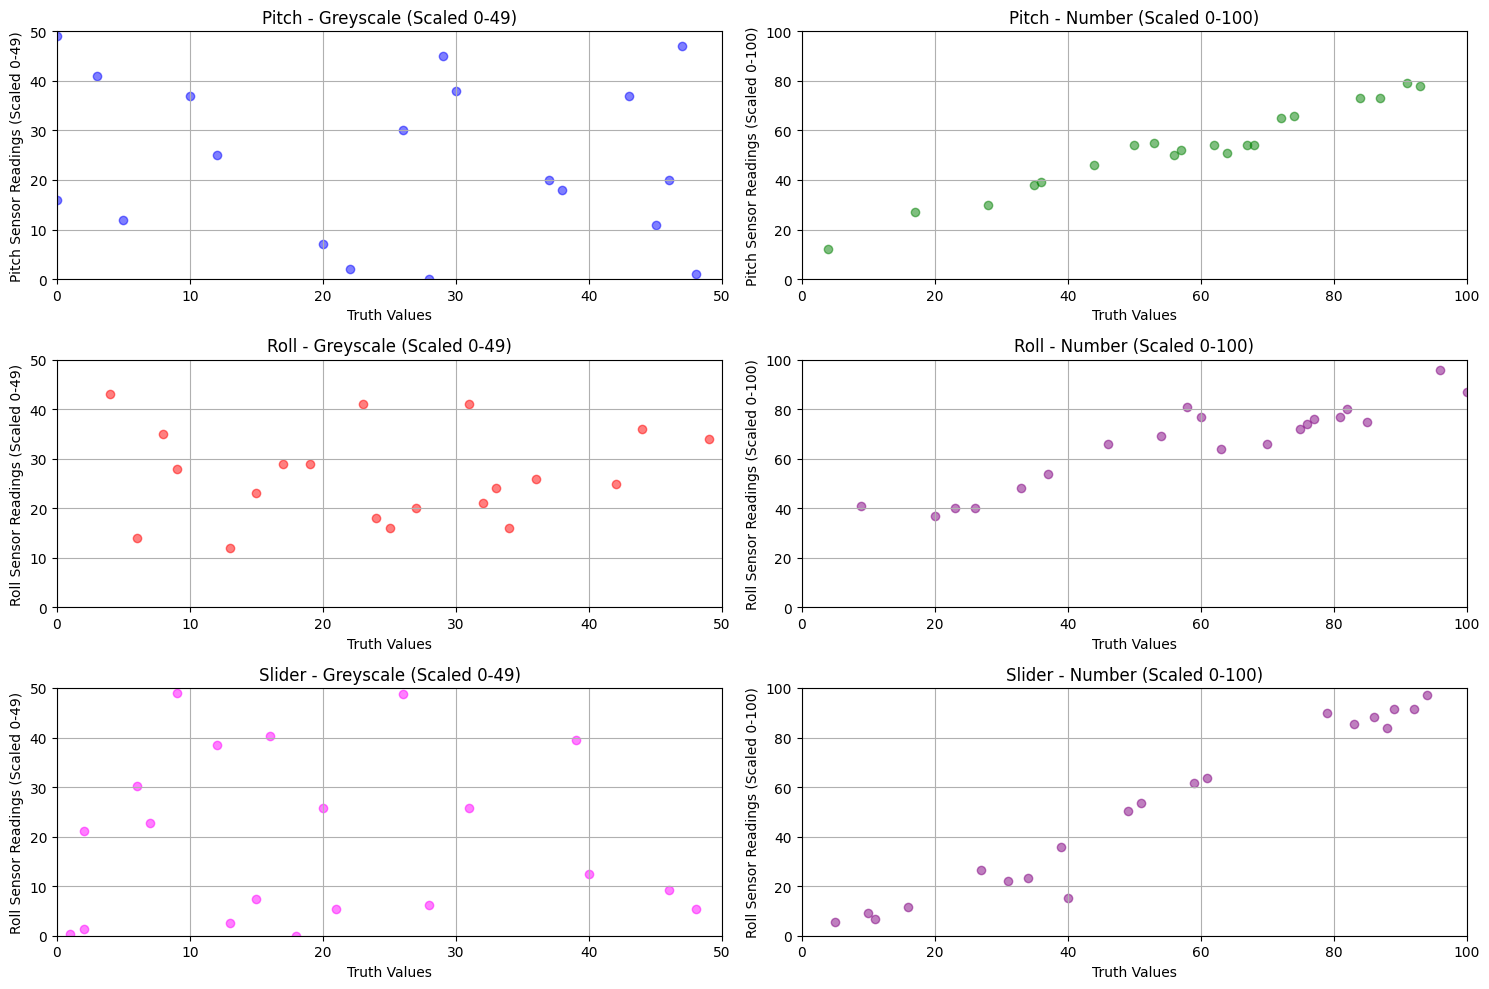

In [209]:
fig, axes = plt.subplots(3, 2, figsize=(15, 10))

g_pitch_greyscale_df = df[df["experiment_type"] == "gesture_pitch_greyscale"]

axes[0, 0].scatter(g_pitch_greyscale_df["truth"], g_pitch_greyscale_df["pitch_truth"], c='blue', alpha=0.5)
axes[0, 0].set_title('Pitch - Greyscale (Scaled 0-49)')
axes[0, 0].set_xlabel('Truth Values')
axes[0, 0].set_ylabel('Pitch Sensor Readings (Scaled 0-49)')
axes[0, 0].grid(True)
axes[0, 0].set_xlim(0, 50)
axes[0, 0].set_ylim(0, 50)


g_pitch_number_df = df[df["experiment_type"] == "gesture_pitch_number"]

axes[0, 1].scatter(g_pitch_number_df["truth"], g_pitch_number_df["pitch_truth"], c='green', alpha=0.5)
axes[0, 1].set_title('Pitch - Number (Scaled 0-100)')
axes[0, 1].set_xlabel('Truth Values')
axes[0, 1].set_ylabel('Pitch Sensor Readings (Scaled 0-100)')
axes[0, 1].grid(True)
axes[0, 1].set_xlim(0, 100)
axes[0, 1].set_ylim(0, 100)

g_roll_greyscale_df = df[df["experiment_type"] == "gesture_roll_greyscale"]

axes[1, 0].scatter(g_roll_greyscale_df["truth"], g_roll_greyscale_df["roll_truth"], c='red', alpha=0.5)
axes[1, 0].set_title('Roll - Greyscale (Scaled 0-49)')
axes[1, 0].set_xlabel('Truth Values')
axes[1, 0].set_ylabel('Roll Sensor Readings (Scaled 0-49)')
axes[1, 0].grid(True)
axes[1, 0].set_xlim(0, 50)
axes[1, 0].set_ylim(0, 50)

g_roll_number_df = df[df["experiment_type"] == "gesture_roll_number"]

axes[1, 1].scatter(g_roll_number_df["truth"], g_roll_number_df["roll_truth"], c='purple', alpha=0.5)
axes[1, 1].set_title('Roll - Number (Scaled 0-100)')
axes[1, 1].set_xlabel('Truth Values')
axes[1, 1].set_ylabel('Roll Sensor Readings (Scaled 0-100)')
axes[1, 1].grid(True)
axes[1, 1].set_xlim(0, 100)
axes[1, 1].set_ylim(0, 100)

g_slider_greyscale_df = df[df["experiment_type"] == "slider_greyscale"]

axes[2, 0].scatter(g_slider_greyscale_df["truth"], g_slider_greyscale_df["value"], c='magenta', alpha=0.5)
axes[2, 0].set_title('Slider - Greyscale (Scaled 0-49)')
axes[2, 0].set_xlabel('Truth Values')
axes[2, 0].set_ylabel('Roll Sensor Readings (Scaled 0-49)')
axes[2, 0].grid(True)
axes[2, 0].set_xlim(0, 50)
axes[2, 0].set_ylim(0, 50)

g_slider_number_df = df[df["experiment_type"] == "slider_number"]

axes[2, 1].scatter(g_slider_number_df["truth"], g_slider_number_df["value"], c='purple', alpha=0.5)
axes[2, 1].set_title('Slider - Number (Scaled 0-100)')
axes[2, 1].set_xlabel('Truth Values')
axes[2, 1].set_ylabel('Roll Sensor Readings (Scaled 0-100)')
axes[2, 1].grid(True)
axes[2, 1].set_xlim(0, 100)
axes[2, 1].set_ylim(0, 100)

plt.tight_layout()
plt.show()